## On plot ensemble les datas

In [1]:
import numpy as np
import torch 
from model import PINNs
from deepxrte.geometry import Rectangle
import pandas as pd
from utils import charge_data
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
with open("results/1_first_try" + "/hyper_param.json", "r") as file:
    hyper_param = json.load(file)

model = PINNs(hyper_param)
checkpoint = torch.load('results/1_first_try'+'/model_weights.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

/tmp/ipykernel_5073/4278516748.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('results/1_first_try'+'/model_weights.pth', map_location=torch.dev

<All keys matched successfully>

In [3]:
param_adim = {
    'V':2,
    'L':0.025,
    'rho': 1.2
}

In [4]:
X_train, U_train, X_full, U_full, X_border, X_border_test, mean_std = charge_data(hyper_param, param_adim)
X_pred = torch.tensor(X_full, dtype=torch.float32)


In [5]:
U_pred = model(X_pred)
x_norm_pred, y_norm_pred, t_norm_pred = X_pred.detach().numpy()[:,0], X_pred.detach().numpy()[:,1], X_pred.detach().numpy()[:,2]
u_norm_pred, v_norm_pred, p_norm_pred = U_pred.detach().numpy()[:,0], U_pred.detach().numpy()[:,1], U_pred.detach().numpy()[:,2]

In [6]:
x_pred = (x_norm_pred*mean_std['x_std'] + mean_std['x_mean'])*param_adim['L']
y_pred = (y_norm_pred*mean_std['y_std'] + mean_std['y_mean'])*param_adim['L']
t_pred = (t_norm_pred*mean_std['t_std'] + mean_std['t_mean'])*(param_adim['L']/param_adim['V'])
u_pred = (u_norm_pred*mean_std['u_std'] + mean_std['u_mean'])*param_adim['V']
v_pred = (v_norm_pred*mean_std['v_std'] + mean_std['v_mean'])*param_adim['V']
p_pred =( p_norm_pred*mean_std['p_std'] + mean_std['p_mean'])*((param_adim['L']**2) * param_adim['rho'])
norme_vitesse_pred = np.sqrt(u_pred**2 + v_pred**2)


In [7]:
u_data = (U_full[:,0]*mean_std['u_std'] + mean_std['u_mean'])*param_adim['V']
v_data = (U_full[:,1]*mean_std['v_std'] + mean_std['v_mean'])*param_adim['V']
p_data =( U_full[:,2]*mean_std['p_std'] + mean_std['p_mean'])*((param_adim['L']**2) * param_adim['rho'])
norme_vitesse_data = np.sqrt(u_data**2 + v_data**2)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

def plot_flow(x, y, t, norme_vitesse_data, norme_vitesse_predict, name_file, fps=7, title='Norme vitesse'):
    # Créer une figure et des axes
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # Ajuster la taille de la figure

    # Déterminer les valeurs min et max pour la colormap
    vmin = min(np.min(norme_vitesse_data), np.min(norme_vitesse_predict))
    vmax = max(np.max(norme_vitesse_data), np.max(norme_vitesse_predict))

    # Initialiser les cartes de chaleur
    indices = np.where(t == np.min(t))
    c1 = ax[0].tripcolor(x[indices],
            y[indices],
            norme_vitesse_data[indices], shading="gouraud", cmap="coolwarm", vmin=vmin, vmax=vmax)
    c2 = ax[1].tripcolor(x[indices],
            y[indices],
            norme_vitesse_predict[indices], shading="gouraud", cmap="coolwarm", vmin=vmin, vmax=vmax)

    ax[0].set_title('Données')
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    
    ax[1].set_title('Prédictions')
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")

    # Ajouter une barre de couleur
    cbar = fig.colorbar(c1, ax=ax, orientation='vertical', label=f"{title}")

    # Fonction d'initialisation
    def init():
        return c1, c2

    # Fonction d'animation
    def update(frame):
        print(frame)
        time = list(set(t))
        time.sort()
        indices = np.where(t == time[frame])
        
        # Mettre à jour la première carte de chaleur
        c1.set_array(norme_vitesse_data[indices].flatten())
        ax[0].set_title('Données')
        
        # Mettre à jour la deuxième carte de chaleur
        c2.set_array(norme_vitesse_predict[indices].flatten())
        ax[1].set_title('Prédictions')

        # Titre général
        plt.suptitle(f"{title} à t={time[frame]:.2f}", fontsize=16)

        return c1, c2

    # Créer l'animation
    ani = FuncAnimation(fig, update, frames=len(set(t)), init_func=init, blit=False, repeat=True)
    ani.save(name_file, writer="pillow", fps=fps)

    plt.show()  # Afficher la figure à la fin

# Exemple d'utilisation
# plot_flow(x, y, t, norme_vitesse_data, norme_vitesse_predict, 'animation.gif')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


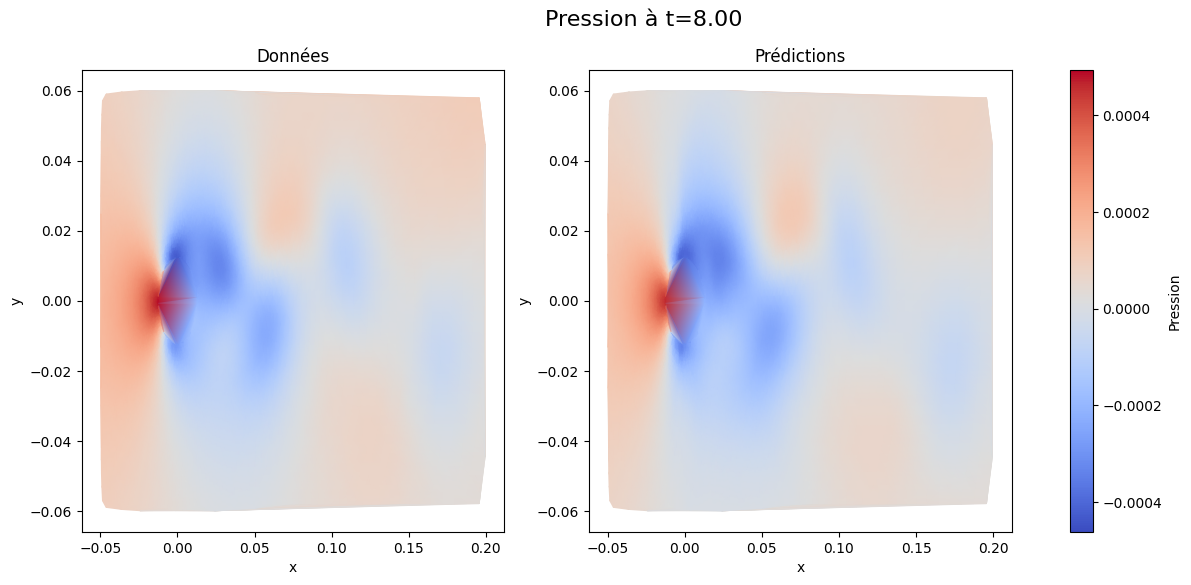

In [9]:
plot_flow(x_pred, y_pred, t_pred, p_data, p_pred, name_file= 'result_pression.gif', title='Pression', fps=5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


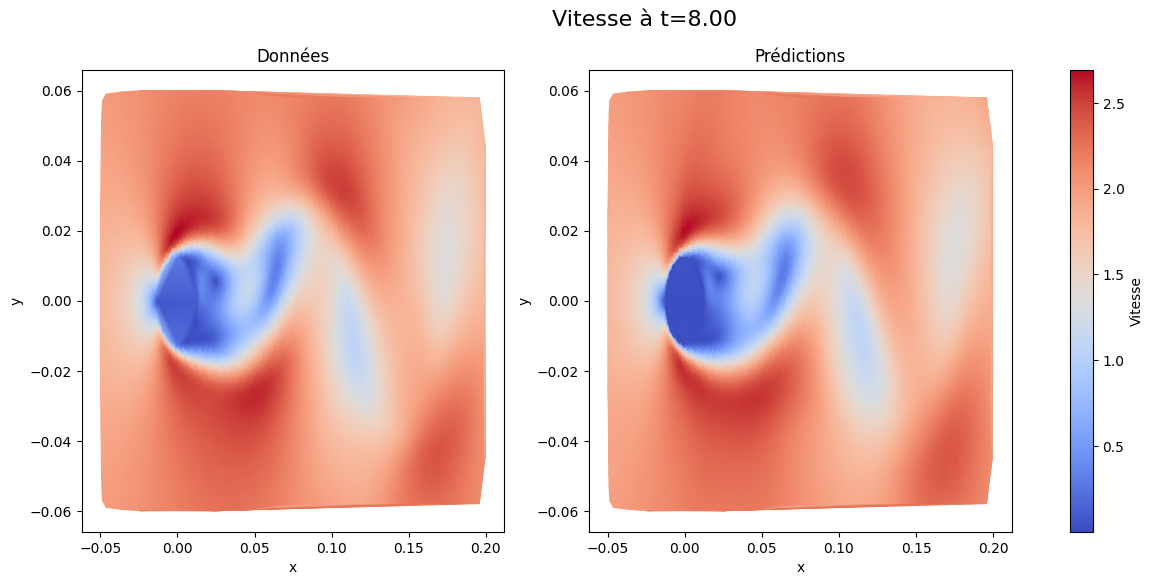

In [10]:
plot_flow(x_pred, y_pred, t_pred, norme_vitesse_data, norme_vitesse_pred, name_file= 'result_vitesse.gif', title='Vitesse', fps=5)